# Introduction

Welcome to the sixth lab. Last week we attacked classification problems expanding the concept of LDA, interpreting the data as generated from probability distributions, into Naïve Bayes. Today we follow the same plan from the perspective of the _margin_, starting with the Perceptron expanding it into the Support Vector Machine.

You will notice we will not implement the learning algorithm this time, because SVMs are solved through quadratic programming and that is not fun. But please feel free to check out quadratic programming yourself if you are interested.

Today we focus on the ample new glossary, then implementing the SVM objective function, and using off-the-shelf optimizers for training. Enjoy!

## Load your libraries

**FROM NOW ON:** take a habit of loading your default libraries, plotting style and external tools at the top of the file (as I do here). I will not mention it further in the next labs, it will be up to you to load what you need.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set(rc={'figure.figsize':(8,6)}, style="whitegrid")

/Users/kimanh/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# 1. Fundamentals

#### 1.1 **[1pt]** Write the equation for the margin (use latex).

The margin on an example (x,y):              $y.f(x_i)$

The margin on a dataset (the boundary margin) is the smallest margin among examples in $D= {(x_1,y_1),...,(x_n,y_n)}$:                      $\gamma = \min_{i} \{(y_i.f(x_i)\}$

#### 1.2 **[2pt]** Write the equation for the maximum margin separation (use latex), then explain it in English below.

Maximum margin separation is an optimization problem to maximize the region between 2 dashed lines:

 $\underset{w,b} \arg\max \{\gamma\}$ s.t $i\in \{1,2,...n\}$
   
   $y_i.(\langle w,x_i \rangle + b) \geq \gamma$\;
    $ \lVert w \rVert =1$

Our goal is maximize the boundary margin $\gamma$ w.r.t parameterization (w,b). The decision boundary is $\langle w,x_i \rangle +b$, and the margin is thus $y_i.(\langle w,x_i \rangle + b)$. We want the margin to be greater than $\gamma$ for all points in the (training) dataset $D$, while maintaining the norm-2 of $w$ equals to 1 

#### 1.3 **[1pt]** When is an *example* (in a dataset) considered a Support Vector? Write its definition using latex, then explain it in English.

#### 1.4 **[1pt]** Explain in English why SVMs ignore examples that are not Support Vectors.

#### 1.5 **[2pt]** Define each of the following concepts (in English): Quadratic Program, Slack Variable, Multiobjective Optimization, with your own words.

Tip: if you want to write something with your own words, you can read a description of it, then put the description away and immediately try to explain it again as if to someone that has no background on it. This of course only works if you have understood the concepts, else you'll find yourself just changing words but reusing the sentences: please avoid that (as the goal is to force you to understand the concepts).  
Incidentally, this is also why studying in pairs/groups works (typically) better: explaining concepts to each other forces you to confront how much did you really understand of it.

#### 1.6 **[3pt]** Write the full formula for the Soft Margin SVM (geometric approach; use latex), then explain in English the role of the hyperparameter C (particularly: what do high or low values mean for the SVM).

#### 1.7 **[2pt]** Write the objective function for the Soft Margin SVM (use latex) using the Regularized Empirical Risk Minimization approach and a Squared Hinge Loss for `L(m)`.

This is no copy-paste, think! Do you remember the difference between the Loss on a _point_, the Loss on a _boundary_, and the _Risk_? You need these concepts super clear for the exam!

# 2. Soft Margin SVM

- Following what we learned in the last exercise: **all** of the questions below need to be solved using Pandas and **no Python loops** (`for`, `while`, etc).
- Let's classify the Iris dataset with a hand-made SVM. Working with margins though means we need to set up once again for **binary classification**. Last time we used the categorical feature type, but this time we need the numerical values for the two classes to be of integer type in $\{-1, 1\}$, because we work with margin calculations. How would you do it? Here's one way to get it done:

In [13]:
df = sns.load_dataset('iris')
# sns.pairplot(df, hue='species')

df.loc[df['species'] == 'setosa', 'species'] = -1
df.loc[df['species'] != -1, 'species'] = 1
df['species'] = pd.to_numeric(df['species'])
print(df.dtypes)
# sns.pairplot(df, hue='species')

     sepal_length  sepal_width  petal_length  petal_width    species
0             5.1          3.5           1.4          0.2     setosa
1             4.9          3.0           1.4          0.2     setosa
2             4.7          3.2           1.3          0.2     setosa
3             4.6          3.1           1.5          0.2     setosa
4             5.0          3.6           1.4          0.2     setosa
..            ...          ...           ...          ...        ...
145           6.7          3.0           5.2          2.3  virginica
146           6.3          2.5           5.0          1.9  virginica
147           6.5          3.0           5.2          2.0  virginica
148           6.2          3.4           5.4          2.3  virginica
149           5.9          3.0           5.1          1.8  virginica

[150 rows x 5 columns]
sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species           int64
dtype: object


Also, do not forget to **split your data** into train set and test set, because using the wrong data you will fail the question. This was introduced in the last lab and will hold until the end of the course. You can copy the code from last submission.

In [23]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2) # 80-20 split

#### 2.1 **[1pt]** Write a Python function that takes in input a row from the Iris dataset (concatenation of $x_i$ and $y_i$), and a parametrization $(w, b)$, and returns the margin.

This is slightly different from what you did so far: rather than pre-splitting the inputs from the labels, you should do the splitting inside the function. You can test the method by passing a (full) single row of the dataset (e.g. `iloc[0]`: notice you do not drop the label). As you should expect, the correct output is one number.

In [29]:
def margin(row,params):
    x = row[:-1]
    y = row[-1]
    w, b = params
    return y * (np.dot(w,x) +b)

w = np.random.rand(4)  #corresponding to 4 elements in x
b = np.random.rand()
params = (w,b)
print(params)

margin(df.iloc[0], params)

(array([0.28275639, 0.55358697, 0.06238324, 0.58515039]), 0.8887204691116836)


-4.472699065878025

#### 2.2 **[1pt]** Write a Python function that takes in input an entire dataset and computes the margins for all points. Use Pandas' `apply()` (remember you cannot use Python loops).

To [unit-test](https://en.wikipedia.org/wiki/Unit_testing) these functions, particularly regarding getting the sizes right, get used to generating random parameter sets of the correct size (using `np.random`). The correct output is a Pandas Series that has the same length as your training set (that is 120 numbers if you went for a 80-20 split).

In [30]:
#Using function apply()

def margins(inp, params):
    return inp.apply(lambda row: margin(row, params), axis= 1)
margins(train, params)

56     5.726365
120    6.312648
43    -4.690960
57     4.393851
108    5.582249
         ...   
15    -5.263850
39    -4.423579
107    6.004529
145    6.114188
60     4.213168
Length: 120, dtype: float64

#### 2.3 **[1pt]** Write a Python function that computes the Squared Hinge Loss for the whole dataset. Re-use the functions defined in answering the previous questions.

- Feel free to define it in two steps, the first being the Loss function for a single number, the second another round of `apply()`.
- You will likely see a lot of zeros in the result, together with some high numbers. _Think: why so?_ Look at the Loss function.
- You can either `apply()` a simple lambda to the output of `margins()`, or a more complex lambda to the dataset directly.

In [31]:
Sq_hloss= lambda m : np.max([0, 1-m])**2

def Sq_hlosses(inp, params):
    return margins(inp,params).apply(Sq_hloss)

Sq_hlosses(train,params)

56      0.000000
120     0.000000
43     32.387028
57      0.000000
108     0.000000
         ...    
15     39.235812
39     29.415206
107     0.000000
145     0.000000
60      0.000000
Length: 120, dtype: float64

#### 2.4 **[2pt]** Write a Python function computing the soft-margin objective function for parametrization $(w, b)$ and hyperparameter `c`. Worth repeating: no loops, use Pandas.

You should be looking for the "unconstrained convex optimization problem" form. Consider using the `linalg` module of numpy, which already gives you an implementation for `norm` (the "standard" norm is already the Euclidean, or _norm-2_). More on norms [here](https://en.wikipedia.org/wiki/Norm_(mathematics)#Euclidean_norm).  
For testing purposes, a simple `c=1.0` will work.

In [37]:
#Soft margin SVM is an unconstrained convex optimization problem:
def opt_fn(inp, params, c):
    w, _ = params
    regularization = 1/2 * np.linalg.norm(w)**2
    violations = c * Sq_hlosses(inp, params).sum()
    return regularization + violations

opt_fn(train, params, 1.0)

1138.4412843185517

#### 2.5 **[4pt]** Train the SVM using Parameter Guessing and print the number of misclassified points.

- We do not want to implement quadratic programming because it is nasty, but we understand that its only role is to find the parameters minimizing a function.
- Copy the _parameter guessing_ method from the first lab, then adapt it to estimate the parameters that _minimize the SVM optimization function_ defined above.
- You still need a loop for Parameter Guessing. The "forbidden loops" are the loops that go over the data points, as their goal is to force you to learn how to do the same, more efficiently, using Pandas. It should be clear by now if a loop is allowed or not.
- The classification with SVM is exactly the same as the Perceptron: positive margin is correct classification, negative is incorrect classification. Remember to use the correct dataset at the right step! (you did split the available data, right?)
- You can make the next question easier by defining two Python functions instead of one: `train_svm(dset_1, c, ntries)` and `test_svm(params, dset_2)` (again, what are those `dset`s?).
- You should not need many guesses to consistently get a decent margin here, try `ntries=100` and `c=1` as defaults, but feel free to play with them after you succeed once.
- For your code to run, you need to debug. This is not a waste of time: if you do it well, it will save time by not having to hunt for difficult errors. The best way to debug is to visualize the progress of the training. Why don't you use the plot of _errors over iterations_ (for the best-so-far) that we first saw with the parameter guessing? If it goes down over time then it's working!

Best params: (array([-0.20744832, -0.39939246,  0.98876137, -0.04382291]), -0.3154867848325065)`
Score: 0.8748729019698285
Number of misclassified points: 0


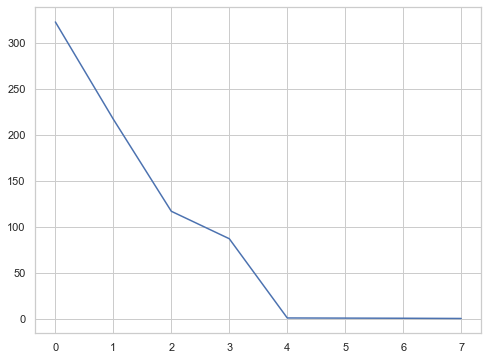

In [44]:
#Define function to find the best params:

def train_svm(dset, c, ntries):
    min_score = np.Infinity
    best_params = None
    best_scores = []
    
    input_size = dset.shape[1]-1  #remove species
    guess_range = [-1,1] #guess parameters in this range

    for _ in range(ntries):
        guess_w = np.random.uniform(*guess_range,input_size)
        guess_b = np.random.uniform(*guess_range)
        params = (guess_w, guess_b)
        
        score = opt_fn(dset, params, c)
        if score < min_score:
            min_score = score
            best_scores.append(min_score)
            best_params = params
    print(f"Best params: {best_params}`\nScore: {best_scores[-1]}")
    sns.lineplot(x= range(len(best_scores)), y= best_scores)
    return best_params

def test_svm(params, dset):
    misclassified = margins(dset, params)<0
    print(f"Number of misclassified points: {misclassified.sum()}")

svm_params = train_svm(train, 1, 1000)
test_svm(svm_params, test)
          

#### 2.6 **[3pt]** Train another SVM, this time using only two features of the Iris dataset: `petal_length` and `petal_width`. Plot the decision boundary of the trained parameters, on top of a scatterplot of the (2D) test set.

- You cannot plot higher-dimensional separation hyperplanes in 2D unless (a) they are perpendicular to the features you want to plot, or (b) you project the points parallel to the hyperplane. So if you want to plot you need to re-train for 2D data. If this is not clear, try to draw an example by hand using a 2D graph but 3D data.
- Careful because starting next week I will resume calling it just "the data", and using the wrong dataset when evaluating the model (i.e. training set) will cause you to **fail** the question. Always train on the _training_ set, you can use cross-validation if you need statistically robust results on little data, you need the _validation_ set for tuning the hyperparameter, and you finally show the results on the _test_ set.
- Start by generating the `train_2d` and `test_2d` datasets, we have already seen how in the past. Then try running your SVM train code.
- Careful: if your implementation hardcoded the number of features, just go back and refactor your code to take the size from the data.
- You are learning parameters `w` and `b`: remember that for plotting you should convert them to `m` and `q`, just another copy+paste.
- Understand that you are not "training" the SVM as much as guessing one that is right. If you want to improve the margin to look nicer, try increasing the number of guesses.
- Feel free to play with `C`. A value of `1.0` here still works, but many applications may need it as high as `1e5` or as low as `1e-5`. Keep it in mind for the next assignment (kernels)!

Best params: (array([0.20295553, 0.85225756]), -0.9458261649460313)`
Score: 14.219201924014538
(array([0.20295553, 0.85225756]), -0.9458261649460313)
Number of misclassified points: 0


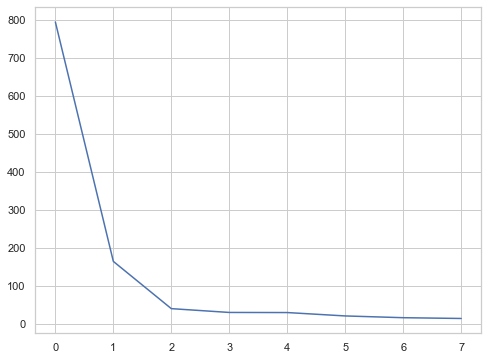

In [51]:
train_2d = train.loc[:,['petal_length', 'petal_width', 'species']]
#print(train_2d)
test_2d = test.loc[:,['petal_length', 'petal_width', 'species']]
#print(test_2d)

svm_params_2d = train_svm(train_2d, 1, 1000)
print(svm_params_2d)
test_svm(svm_params_2d, test_2d)

m: -0.23813872753515217, q: 1.109789120484857
Boundary: `y ='-0.24'x + '1.11'


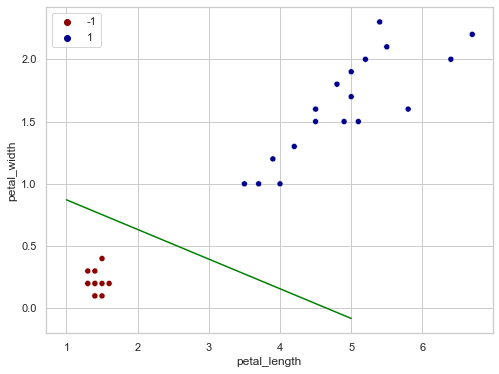

In [54]:
def wb2mq(w, b):
    assert len(w) == 2, "This implementation only works in 2D"
    assert w[0] != 0 and w[1] != 0 and b != 0 # avoid edge cases for now
    return [w[0]/-w[1], b/-w[1]] # here are m and q

def params2boundary(w, b):
    m, q = wb2mq(w, b)
    print(f"m: {m}, q: {q}")
    print(f"Boundary: `y ='{round(m,2)}'x + '{round(q,2)}'")
    return lambda x: m*x + q

#Decision boundary of trained parameters
boundary = params2boundary(*svm_params_2d)  #remember the splat

#Plot of the 2D testset
def plot_data():
    sns.scatterplot(data = test_2d,
               x = 'petal_length',
               y = 'petal_width',
               palette = sns.color_palette(['darkred', 'darkblue'],),
               hue = 'species')
def plot_model(model):
    x_space = np.linspace(1,5)
    sns.lineplot(x= x_space, y=model(x_space), color='green')

plot_data()
plot_model(boundary)
                

#### 2.7 **[2pt]** Classify the 2D dataset using the [scikit-learn implementation](https://scikit-learn.org/stable/modules/svm.html). Mandatory: (i) use the `LinearSVC` implementation (as we did not study kernels yet); (ii) use the same Loss function as in your hand-made implementation (should be easy enough to find), (iii) use a custom value of `C` that tends to ignore margin violations more than $1.0$, but without misclassifying data.

- SVC stands for "Support Vector (Machine) Classifier", while SVR uses the same trick for Regression (**do not** use it here).
- Class `LinearSVC` underneath uses the `liblinear` library, which is highly optimized for linear SVMs. Class `SVC` on the other hand uses `libsvm`, which is more optimized for nonlinear SVMs using kernels. In some cases you may actually get better results on the default parameters with `SVC(kernel='linear')` than you do with `LinearSVC()`, but the latter has a more flexible parametrization (for linear boundaries only), so eventually you should have more room for improvement (you can use a validation set to search for better hyperparaters).
- Remember that this question requires you to access the right datasets for training and test phases, and that you need to split the `x` and `y` as seen last week with NB (that's Naïve Bayes and yes next time you see NB that is what you should expect to mean). 
- You may be tempted to try passing a straight `0` to `C`. Many implementations give errors for `C=0`, but you can get around it by passing a good enough approximation :) remember you can use the scientific notation `1e-x` for decimals, but you really don't need it too small: with a low enough `C` you will start getting misclassified points! Give it a try: do you understand why this happens? (spoiler/hint: think about the English meaning of "maximizing the _margin_ without restrictions", how big a margin can you make if you wish to?)

In [64]:
from sklearn.svm import LinearSVC
x_train= train_2d.iloc[:,:-1]
y_train= train_2d.iloc[:,-1]
x_test= test_2d.iloc[:,:-1]
y_test= test_2d.iloc[:,-1]

model = LinearSVC(loss= 'squared_hinge', C= 0.1)
trained = model.fit(x_train, y_train)
y_pred = trained.predict(x_test)
n_misclassified = (y_pred!=y_test).sum()
print(n_misclassified)


0


#### 2.8 **[1pt]** Plot the decision boundary of the SVM over the dataset.

Think carefully and don't mess this up: _which dataset does the question refer to?_ Remember, from now on, we always split our initial data into (at least) two datasets, and all questions referring to learning the parameters use one of the two datasets, while all questions referring to showing the learned model performance should use the other.

[[0.35584697 0.5677773 ]]
[-1.34696132]
m: -0.6267368727119363, q: 2.372340903615634
Boundary: `y ='-0.63'x + '2.37'


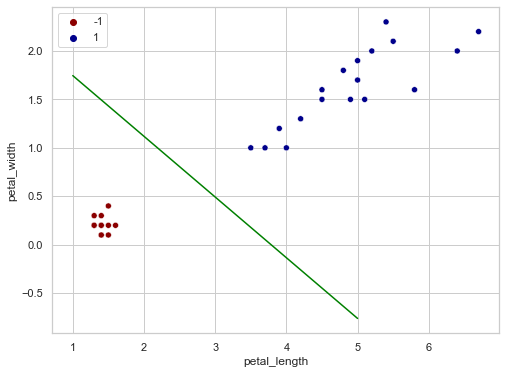

In [66]:
#The question refer to testset which embeded in plot_data() function above:
print(trained.coef_)  #gives an array of w and bias
print(trained.intercept_)  #gives b

skl_params = [trained.coef_[0], trained.intercept_[0]]
skl_boundary = params2boundary(*skl_params)

plot_data()
plot_model(skl_boundary)

# At the end of the exercise

Bonus question with no points! Answering this will have no influence on your scoring, not at the assignment and not towards the exam score -- really feel free to ignore it with no consequence. But solving it will reward you with skills that will make the next lectures easier, give you real applications, and will be good practice towards the exam.

The solution for this questions will not be included in the regular lab solutions pdf, but you are welcome to open a discussion on the Moodle: we will support your addressing it, and you may meet other students that choose to solve this, and find a teammate for the next assignment that is willing to do things for fun and not only for score :)

#### BONUS **[ZERO pt]** Train an SVM on the full Iris dataset (3 classes) using `libsvm`, and print the number of misclassified points. Play with `C` and see how this changes.

#### BONUS **[ZERO pt]** Train you hand-written SVM implementation using the [PEGASOS algorithm](https://github.com/ejlb/pegasos). Now you have a state-of-the-art implementation, congrats! It will actually run better than the scikit-learn `LinearSVM` and `SVC` implementations. Remember this when you need a quick ML result in the future, especially over large data, and performance matters!

To install pegasos (or any other GitHub repository) just switch to a local environment (as shown in the last lecture), then run (from your assignments folder):
```bash
pipenv install -e 'git+https://github.com/ejlb/pegasos.git#egg=pegasos'
```
Here is probably the most complete [guide to Pipenv](https://realpython.com/pipenv-guide). I do not expect a full read (I didn't myself); but if you need something from Pipenv, a quick search in that page will likely point you in the right direction.

If you want to run on `colab`, this could be the right time for you to learn about using "bang commands" in Jupyter notebooks ("bang" being an exclamation mark `!`): they will be run in the shell that is running the Jupyter server. For example you can use `!pip install`. But as mentioned, this is just a hack as you have limited and blind control over your environment, and particularly it will give you problems as soon as you start collaborating with other people on other platforms (the solution is of course a local installation with Pipenv).

### Final considerations

- SVMs are optimal -- when applicable. In particular, if your data is bounded on all features, and you have enough samples from the whole range (so that new points in the test set are expected to be within the same range), then its performance are awesome. And if the data's underlying function is not overly complicated, you don't need an overly complicated model. In the real world and with real data, you are almost guaranteed to get to using a SVM for an application or another at some point in time.
- Remember that easy problems can be often solved with parameter guessing; this also means that if you can solve a problem with parameter guessing, it is an easy problem :) much depends on the model though, with the right model guessing the parameters is efficient, with the wrong model both guessing and training performance drops.
- The main limitation left at this point is handling non-linearities in the data. This is exactly the topic for the next lecture. Be ready as it is more math intensive than linear SVM, but you should have all the pieces now to grasp it completely in the next week.